In [1]:
import os
from dotenv import load_dotenv

load_dotenv()  

openai_key = os.getenv("OPENAI_API_KEY")
gemini_key = os.getenv("GEMINI_API_KEY")
langchain_key = os.getenv("LANGCHAIN_API_KEY")


In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "** "
os.environ["GEMINI_API_KEY"] = "**"
os.environ["LANGCHAIN_API_KEY"] = "**"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [4]:
from unstructured.partition.pdf import partition_pdf

output_path = "content"
file_path = "content/content.pdf"  

chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,           
    strategy="hi_res",                     

    extract_image_block_types=["Image"],   
 

    extract_image_block_to_payload=True,   

    chunking_strategy="by_title",          
    max_characters=10000,                 
    combine_text_under_n_chars=2000,       
    new_after_n_chars=6000,
)

Loading weights:   0%|          | 0/367 [00:00<?, ?it/s]

In [5]:
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [6]:
chunks[3].metadata.orig_elements

In [7]:
len(chunks)

9

In [8]:
elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': 'dce1a9ce-1092-4479-8b0f-43873ac41515',
 'text': '',
 'metadata': {'coordinates': {'points': ((486.0, 261.1805555555558),
    (486.0, 614.7805555555556),
    (664.0, 614.7805555555556),
    (664.0, 261.1805555555558)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2026-02-12T16:02:41',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 4,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFiALIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQE

In [30]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    # 1. All chunks from 'by_title' strategy are CompositeElements (Text chunks)
    if "CompositeElement" in str(type(chunk)):
        texts.append(chunk)
        
        # 2. Look INSIDE the chunk for Table elements
        # The original elements (like Table) are stored in metadata.orig_elements
        if hasattr(chunk.metadata, "orig_elements") and chunk.metadata.orig_elements:
            for el in chunk.metadata.orig_elements:
                if "Table" in str(type(el)):
                    tables.append(el)

print(f"Found {len(texts)} text chunks.")
print(f"Found {len(tables)} tables.")

Found 9 text chunks.
Found 3 tables.


In [10]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

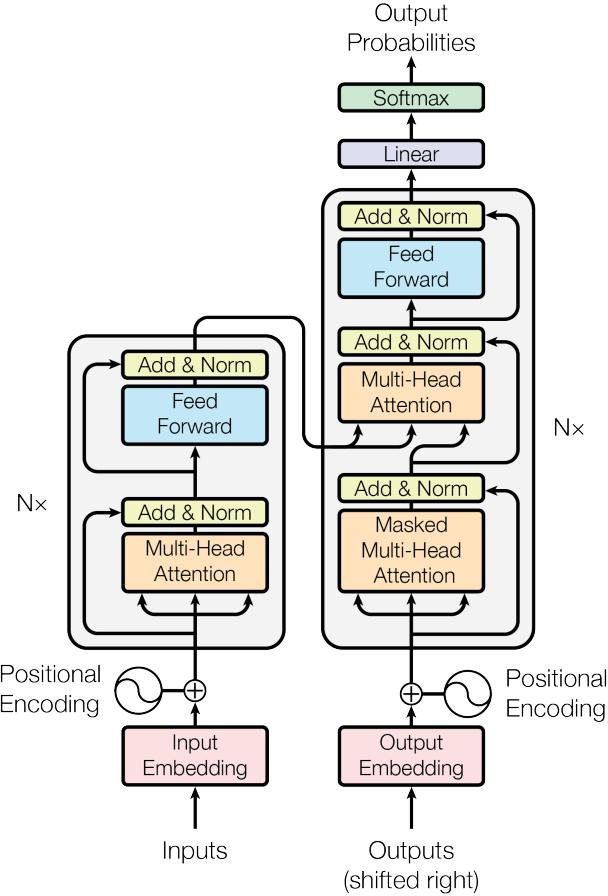

In [11]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

In [12]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

/Users/rohansi/Downloads/multimodal/venv/lib/python3.10/site-packages/google/api_core/_python_version_support.py:275: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
/Users/rohansi/Downloads/multimodal/venv/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:47: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  from google.generativeai.caching import CachedContent  # type: ignore[import]


In [14]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}
"""

prompt = ChatPromptTemplate.from_template(prompt_text)

# Gemini model
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=gemini_key,
    temperature=0.5
)

# Summary chain
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [31]:
# Get the HTML representation of the tables for the LLM
# Note: Ensure 'infer_table_structure=True' was used in partition_pdf (which you did)
tables_html = [table.metadata.text_as_html for table in tables]

# Generate summaries
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

print(f"Generated {len(table_summaries)} table summaries.")

Generated 3 table summaries.


In [16]:
text_summaries

['The Transformer is a novel neural network architecture that relies solely on attention mechanisms, completely dispensing with recurrence and convolutions. It offers superior quality, greater parallelization, and significantly reduced training time compared to traditional recurrent or convolutional models. The Transformer achieved state-of-the-art results on machine translation tasks, including 28.4 BLEU on WMT 2014 English-to-German and 41.0 BLEU on WMT 2014 English-to-French, with substantially lower computational costs.',
 'The Transformer model addresses the challenge of reducing sequential computation and learning long-range dependencies, a limitation in prior convolutional models like ConvS2S and ByteNet where operation costs grow with distance. It achieves this by reducing the number of operations to relate distant positions to a constant, utilizing self-attention, which is enhanced by Multi-Head Attention. Self-attention, an intra-attention mechanism, has proven effective in v

In [32]:
table_summaries

['The table compares Self-Attention, Recurrent, Convolutional, and Restricted Self-Attention layer types based on their complexity, sequential operations, and maximum path length. Self-Attention and Convolutional layers feature O(1) sequential operations, offering high parallelism, in contrast to Recurrent layers which have O(n) sequential operations. Complexity ranges from O(rnd) for restricted Self-Attention to O(n²d) for full Self-Attention, while maximum path length varies from O(1) to O(n).',
 'The table compares various machine translation models, including ByteNet, Deep-Att, GNMT, ConvS2S, MoE, and Transformer, across EN-DE and EN-FR translation tasks. It reports BLEU scores for both language pairs and training FLOPs. Transformer (big) achieves the highest EN-DE score (28.4), while ConvS2S Ensemble and GNMT + RL Ensemble show the highest EN-FR scores (41.29 and 41.16 respectively). Ensemble methods generally improve performance over single models. Training FLOPs vary significant

In [18]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images)

In [19]:
image_summaries

['The image depicts the architecture of the Transformer model, which is a key component in natural language processing tasks. It consists of several main elements detailed in the structure.\n\n### Structure Overview\n1. **Input and Output Embeddings**:\n   - At the bottom, there are two sections labeled "Input Embedding" and "Output Embedding," both fed by "Positional Encoding." These embeddings transform the input and output sequences into vector representations.\n  \n2. **Layers**:\n   - The architecture features a stack of identical layers, represented as "N×" on the left and right sides. This suggests that the model can have multiple layers (N) for both the encoder and decoder.\n   \n3. **Encoder**:\n   - In the encoder section (left side), the layers contain:\n     - **Multi-Head Attention**: This block allows the model to focus on different positions of the input sequence simultaneously.\n     - **Add & Norm**: After the attention mechanism, a residual connection is added followe

In [20]:
print(image_summaries[1])

The image depicts a flowchart illustrating a component of the transformer architecture, specifically focusing on the attention mechanism. 

### Description:

1. **Structure**:
   - The chart is vertically oriented, with rectangular boxes containing text connected by arrows.

2. **Boxes**:
   - **MatMul**: At the top, there’s a purple box labeled "MatMul," indicating a matrix multiplication operation. This is a common operation in neural networks, particularly in the context of calculating attention scores.
   
   - **SoftMax**: Below this, a green box is labeled "SoftMax," which represents the step where the attention scores are normalized into probabilities.

   - **Mask (opt.)**: There’s an optional masking step shown next to the SoftMax, indicated by a pink box. This masking is used to prevent attention to certain positions during training or inference.
   
   - **Scale**: Below the Mask step, a yellow box labeled "Scale" is included, suggesting that the attention scores may be scal

In [21]:
import uuid
from langchain_chroma import Chroma
from langchain_core.stores import InMemoryStore 
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever


# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [ ]:
import uuid
from langchain_core.documents import Document

# Ideally, 'id_key' should match what you defined in the retriever initialization
id_key = "doc_id"

# --- 1. Add Text Summaries (The "Parent" Docs) ---
if len(text_summaries) > 0:
    # Generate unique IDs for each text chunk
    doc_ids = [str(uuid.uuid4()) for _ in texts]
    
    # Create the summary documents (These go into the VectorStore for searching)
    summary_texts = [
        Document(page_content=summary, metadata={id_key: doc_ids[i]}) 
        for i, summary in enumerate(text_summaries)
    ]
    
    # Add summaries to VectorStore
    retriever.vectorstore.add_documents(summary_texts)
    
    # Add original raw texts to DocStore (These are returned after search)
    retriever.docstore.mset(list(zip(doc_ids, texts)))
    print(f"Added {len(text_summaries)} text summaries to the retriever.")
else:
    print("ℹNo text summaries found to add.")


# --- 2. Add Table Summaries ---
if len(table_summaries) > 0:
    # Generate unique IDs for each table
    table_ids = [str(uuid.uuid4()) for _ in tables]
    
    # Create the summary documents
    summary_tables = [
        Document(page_content=summary, metadata={id_key: table_ids[i]}) 
        for i, summary in enumerate(table_summaries)
    ]
    
    # Add summaries to VectorStore
    retriever.vectorstore.add_documents(summary_tables)
    
    # Add original raw tables to DocStore
    retriever.docstore.mset(list(zip(table_ids, tables)))
    print(f"Added {len(table_summaries)} table summaries to the retriever.")
else:
    print("ℹ️ No tables found to add.")


# --- 3. Add Image Summaries ---
if len(image_summaries) > 0:
    # Generate unique IDs for each image
    img_ids = [str(uuid.uuid4()) for _ in images]
    
    # Create the summary documents
    summary_img = [
        Document(page_content=summary, metadata={id_key: img_ids[i]}) 
        for i, summary in enumerate(image_summaries)
    ]
    
    # Add summaries to VectorStore
    retriever.vectorstore.add_documents(summary_img)
    
    # Add original raw images (Base64) to DocStore
    retriever.docstore.mset(list(zip(img_ids, images)))
    print(f"Added {len(image_summaries)} image summaries to the retriever.")
else:
    print("ℹNo images found to add.")

print("\nAll data indexed successfully!")

✅ Added 9 text summaries to the retriever.
ℹ️ No tables found to add.
✅ Added 3 image summaries to the retriever.

🎉 All data indexed successfully!


In [24]:
# Retrieve
docs = retriever.invoke(
    "who are the authors of the paper?"
)

In [25]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

7 Conclusion

In this work, we presented the Transformer, the ﬁrst sequence transduction model based entirely on attention, replacing the recurrent layers most commonly used in encoder-decoder architectures with multi-headed self-attention.

For translation tasks, the Transformer can be trained signiﬁcantly faster than architectures based on recurrent or convolutional layers. On both WMT 2014 English-to-German and WMT 2014 English-to-French translation tasks, we achieve a new state of the art. In the former task our best model outperforms even all previously reported ensembles.

We are excited about the future of attention-based models and plan to apply them to other tasks. We plan to extend the Transformer to problems involving input and output modalities other than text and to investigate local, restricted attention mechanisms to efﬁciently handle large inputs and outputs such as images, audio and video. Making generation less sequential is another research goals of ours.

The code w

In [27]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """
    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [28]:
response = chain.invoke(
    "What is the attention mechanism?"
)

print(response)

The attention mechanism referred to in the context is called "Scaled Dot-Product Attention." It operates by taking inputs in the form of queries (Q), keys (K), and values (V), each with specific dimensions. The mechanism follows these steps:

1. **Dot Product Calculation**: It computes the dot products of the query with all keys.
2. **Scaling**: Each dot product is divided by the square root of the dimension of the keys (dk) to prevent large values from pushing the softmax function into regions with small gradients.
3. **Softmax Application**: A softmax function is applied to the scaled dot products to obtain attention weights on the values.
4. **Weighted Sum**: The attention weights are then used to compute a weighted sum of the values.

This process allows the model to focus on different parts of the input sequence when making predictions. Additionally, the "Multi-Head Attention" extends this by applying multiple attention mechanisms in parallel to capture information from different 

In [29]:
import json

response = chain_with_sources.invoke(
    "What is multihead?"
)

# --- Output formatting only (no logic changes) ---
answer = response.get("response", "")
ctx = response.get("context", {})

sources = []
for t in ctx.get("texts", []):
    sources.append(
        {
            "page_number": getattr(getattr(t, "metadata", None), "page_number", None),
            "text": getattr(t, "text", None) or str(t),
        }
    )

images_b64 = [str(i) for i in ctx.get("images", [])]

frontend_payload = {
    "answer": answer,
    "sources": sources,
    "images": images_b64,
}

# This JSON shape is easy to render in the frontend.
print(json.dumps(frontend_payload, indent=2, ensure_ascii=False))

# Optional: preview images inline in the notebook
for image in images_b64:
    display_base64_image(image)


Response: Multi-head attention is a mechanism used in the Transformer model that allows the model to jointly attend to information from different representation subspaces at different positions. Instead of performing a single attention function, multi-head attention involves multiple attention layers (or heads) running in parallel. Each head applies attention to different linear projections of the queries, keys, and values, which enables the model to capture various aspects of the input data.

The outputs from these multiple attention heads are concatenated and then projected again to generate the final output values. This approach helps the model to gather more comprehensive contextual information by attending to different parts of the input simultaneously, rather than averaging the information from a single attention head.


Context:
7 Conclusion

In this work, we presented the Transformer, the ﬁrst sequence transduction model based entirely on attention, replacing the recurrent laye